In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import warnings
import itertools
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm

### Czarne punkty na mapie to stacje z których są pobierane informacje

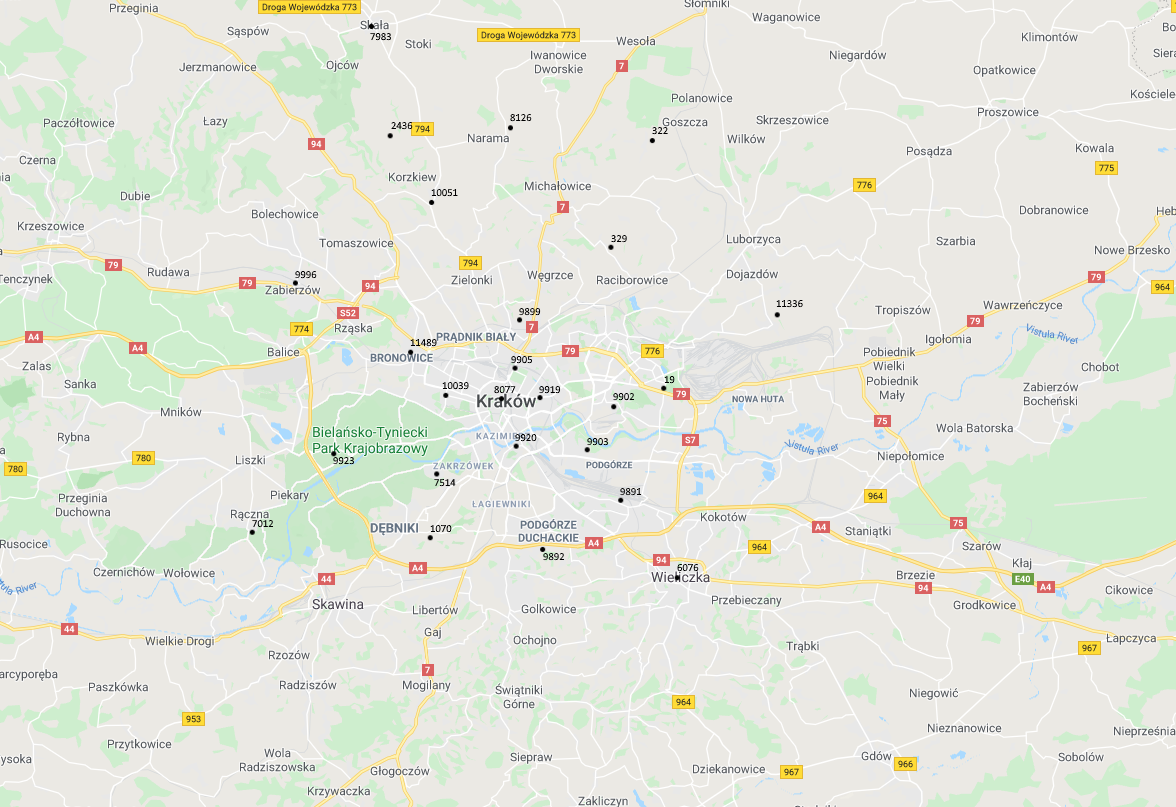

In [3]:
from IPython.display import Image
Image(filename='mapa_google.png') 
# TODO: oznaczyc kazda ze stacji jednym kolorem by byly zawsze takie same na wykresach

## Wczytanie danych z pliku csv

In [4]:
df = pd.read_csv('./dane.csv', header = 0).iloc[:, 1:]
df = df.drop(columns=['indexLevel'])

In [5]:
df['fromDataTime'] = df['fromDataTime'].apply(lambda x: pd.to_datetime(x))
df['tillDateTime'] = df['tillDateTime'].apply(lambda x: pd.to_datetime(x))

dayOfWeekMap = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
df['dayOfWeek'] = df['dayOfWeek'].apply(lambda x: dayOfWeekMap[x])
df['coronavirus'] = df['coronavirus'].apply(lambda x: 1 if x else 0)
df['typeOfDay'] = df['typeOfDay'].apply(lambda x: 1 if x == 'Weekend' else 0)

In [33]:
df

installationId        fromDataTime        tillDateTime    PM1   PM10  \
0                313 2020-04-24 18:00:00 2020-04-24 19:00:00  24.85  71.28   
1               8126 2020-04-24 18:00:00 2020-04-24 19:00:00   9.91  28.54   
2                332 2020-04-24 18:00:00 2020-04-24 19:00:00  10.68  26.75   
3              10051 2020-04-24 18:00:00 2020-04-24 19:00:00  25.39  52.09   
4               9899 2020-04-24 18:00:00 2020-04-24 19:00:00   8.63  18.39   
...              ...                 ...                 ...    ...    ...   
7825            7012 2020-05-10 19:00:00 2020-05-10 20:00:00  12.77  29.64   
7826            9996 2020-05-10 19:00:00 2020-05-10 20:00:00    NaN  34.08   
7827           11489 2020-05-10 19:00:00 2020-05-10 20:00:00  13.59  32.04   
7828           10039 2020-05-10 19:00:00 2020-05-10 20:00:00  13.32  29.21   
7829            8077 2020-05-10 19:00:00 2020-05-10 20:00:00   9.61  22.75   

       PM25  PRESSURE  HUMIDITY  TEMPERATURE  indexValue  NO2  CO  CLOUDCOVER  \
0     38.85   1004.98     45.34        14.56       63.30  NaN NaN          96   
1     16.22   1005.01     47.07        14.10       28.54  NaN NaN          95   
2     14.60   1004.28     30.83        14.93       26.75  NaN NaN          96   
3     40.54   1004.37     42.69        14.48       60.54  NaN NaN          96   
4     10.94   1006.63     41.77        16.04       18.39  NaN NaN          97   
...     ...       ...       ...          ...         ...  ...  ..         ...   
7825  17.85   1005.73     60.81        19.64       29.75  NaN NaN         100   
7826    NaN   1006.00     63.00        19.33       34.08  NaN NaN         100   
7827  18.02   1007.14     58.01        19.33       32.04  NaN NaN         100   
7828  17.51   1007.57     36.25        18.55       29.21  NaN NaN         100   
7829  13.09   1007.18     54.91        19.95       22.75  NaN NaN         100   

      WINDDIRECTION  WINDSPEED  dayOfWeek  coronavirus  typeOfDay  
0             240.0        2.6          5            1          0  
1             240.0        2.6          5            1          0  
2             240.0        2.6          5            1          0  
3             240.0        2.6          5            1          0  
4             240.0        2.6          5            1          0  
...             ...        ...        ...          ...        ...  
7825            NaN        0.5          7            1          1  
7826            NaN        0.5          7            1          1  
7827            NaN        0.5          7            1          1  
7828            NaN        0.5          7            1          1  
7829            NaN        0.5          7            1          1  

[7830 rows x 18 columns]

In [254]:
installationd_id = df['installationId'].unique()
installationd_id.sort()
measurements_by_installation_id = dict()
for id in installationd_id:
    measurements_by_installation_id[id] = df.loc[df['installationId'] == id]

In [255]:
installations = pd.read_csv('./installation.csv', header = 0).iloc[:, :]
installations

id   latitude  longitude country                city  \
0      19  50.069308  20.053492  Poland              Kraków   
1     329  50.131500  20.014326  Poland         Ksiazniczki   
2     332  50.175018  20.039064  Poland  Zagórzyce Dworskie   
3    1070  50.002872  19.891985  Poland              Kraków   
4    6076  49.985546  20.059961  Poland           Wieliczka   
5    7012  50.006187  19.769005  Poland              Raczna   
6    7514  50.033099  19.895774  Poland              Kraków   
7     313  50.230379  19.853520  Poland               Skala   
8    8077  50.062006  19.940984  Poland              Kraków   
9    8126  50.185143  19.947767  Poland            Kozierów   
10   9891  50.020586  20.022960  Poland              Kraków   
11   9892  49.999615  19.966073  Poland              Kraków   
12   9899  50.099239  19.953954  Poland              Kraków   
13   9902  50.062677  20.018922  Poland              Kraków   
14   9903  50.044067  19.998804  Poland              Kraków   
15   9905  50.079672  19.949190  Poland              Kraków   
16   9919  50.066747  19.962083  Poland              Kraków   
17   9920  50.044424  19.952205  Poland              Kraków   
18   9923  50.042476  19.826993  Poland              Kraków   
19   9996  50.116028  19.800639  Poland           Zabierzów   
20  10039  50.067312  19.903360  Poland              Kraków   
21  10051  50.150282  19.893212  Poland         Januszowice   
22  11336  50.114638  20.131619  Poland     Krzysztoforzyce   
23  11489  50.084966  19.877998  Poland              Kraków   

                          street buildingNumber  elevation  airly  
0                      Bulwarowa             30     203.87      0  
1                            NaN            NaN     227.36      1  
2                            NaN            NaN     315.70      1  
3              Profesora Geremka             26     245.78      1  
4           Stanislawa Moniuszki              1     240.53      1  
5                            NaN            NaN     223.38      1  
6                        Skalica            21B     212.05      1  
7                          Rynek          20-21     416.64      0  
8                     Mikolajska              4     220.38      1  
9                            NaN            NaN     359.71      1  
10  Komandora Bohdana Wronskiego              9     199.94      1  
11                       Wyzynna             30     235.34      1  
12        Macieja Slomczynskiego             18     240.98      1  
13                   Soltysowska            12G     198.28      1  
14                     Mysliwska             59     197.37      1  
15                       Rogatka              3     215.60      1  
16                      Kielecka     6/6 31-526     208.91      1  
17                       Krakusa             11     205.57      1  
18                        Dworna             46     228.21      1  
19                      Kolejowa             26     235.00      0  
20                      Reymonta             37     203.88      1  
21                           NaN            NaN     261.88      1  
22                           NaN            NaN     236.89      1  
23         osiedle Zlota Podkowa             36     230.22      1

## Nazwy stacji

In [36]:
installations_labels = dict()
for _, installation in installations.iterrows():
    installation_name = '%s - %s' % (installation['city'], installation['street'])
    installations_labels[installation['id']] = installation_name

## Wyliczenie okresów kiedy były weekendy

In [37]:
import datetime
holidays = [datetime.datetime(2020, 5, 1).date(), datetime.datetime(2020, 5, 3).date()]
coronavirus = [datetime.datetime(2020, 4, 24).date(), datetime.datetime.now().date()]
begin_date = datetime.datetime(2020, 4, 24)
end_date = datetime.datetime(2020, 4, 25)
weekends = []
while end_date < datetime.datetime.now():
    weekends.append((begin_date.date(), end_date.date()))
    begin_date = begin_date + datetime.timedelta(days=7)
    end_date = end_date + datetime.timedelta(days=7)

## Wykresy wszystykich stacji

In [38]:
def setup_x_axis(ax, measurements):
    days = mdates.DayLocator()
    days_fmt = mdates.DateFormatter('%m-%d')
    
    ax.xaxis.set_major_locator(days)
    ax.xaxis.set_major_formatter(days_fmt)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.axvspan(holidays[0], holidays[1], color='red', alpha=0.5)
    ax.axvspan(coronavirus[0], coronavirus[1], color='green', alpha=0.1)
    for (start, end) in weekends:
        ax.axvspan(start, end, color='blue', alpha=0.3)
    ax.grid(True)

In [39]:
import matplotlib.dates as mdates

def plotAllData(column: str):
    fig, ax = plt.subplots()

    fig.set_figheight(15)
    fig.set_figwidth(30)
    for id, measurements in measurements_by_installation_id.items():
        ax.plot(measurements.fromDataTime, measurements[column], label=installations_labels[id])

    setup_x_axis(ax, measurements)

    plt.xlabel('Dzień')
    plt.ylabel(column)
    plt.title(column)
    plt.legend()

    plt.show()

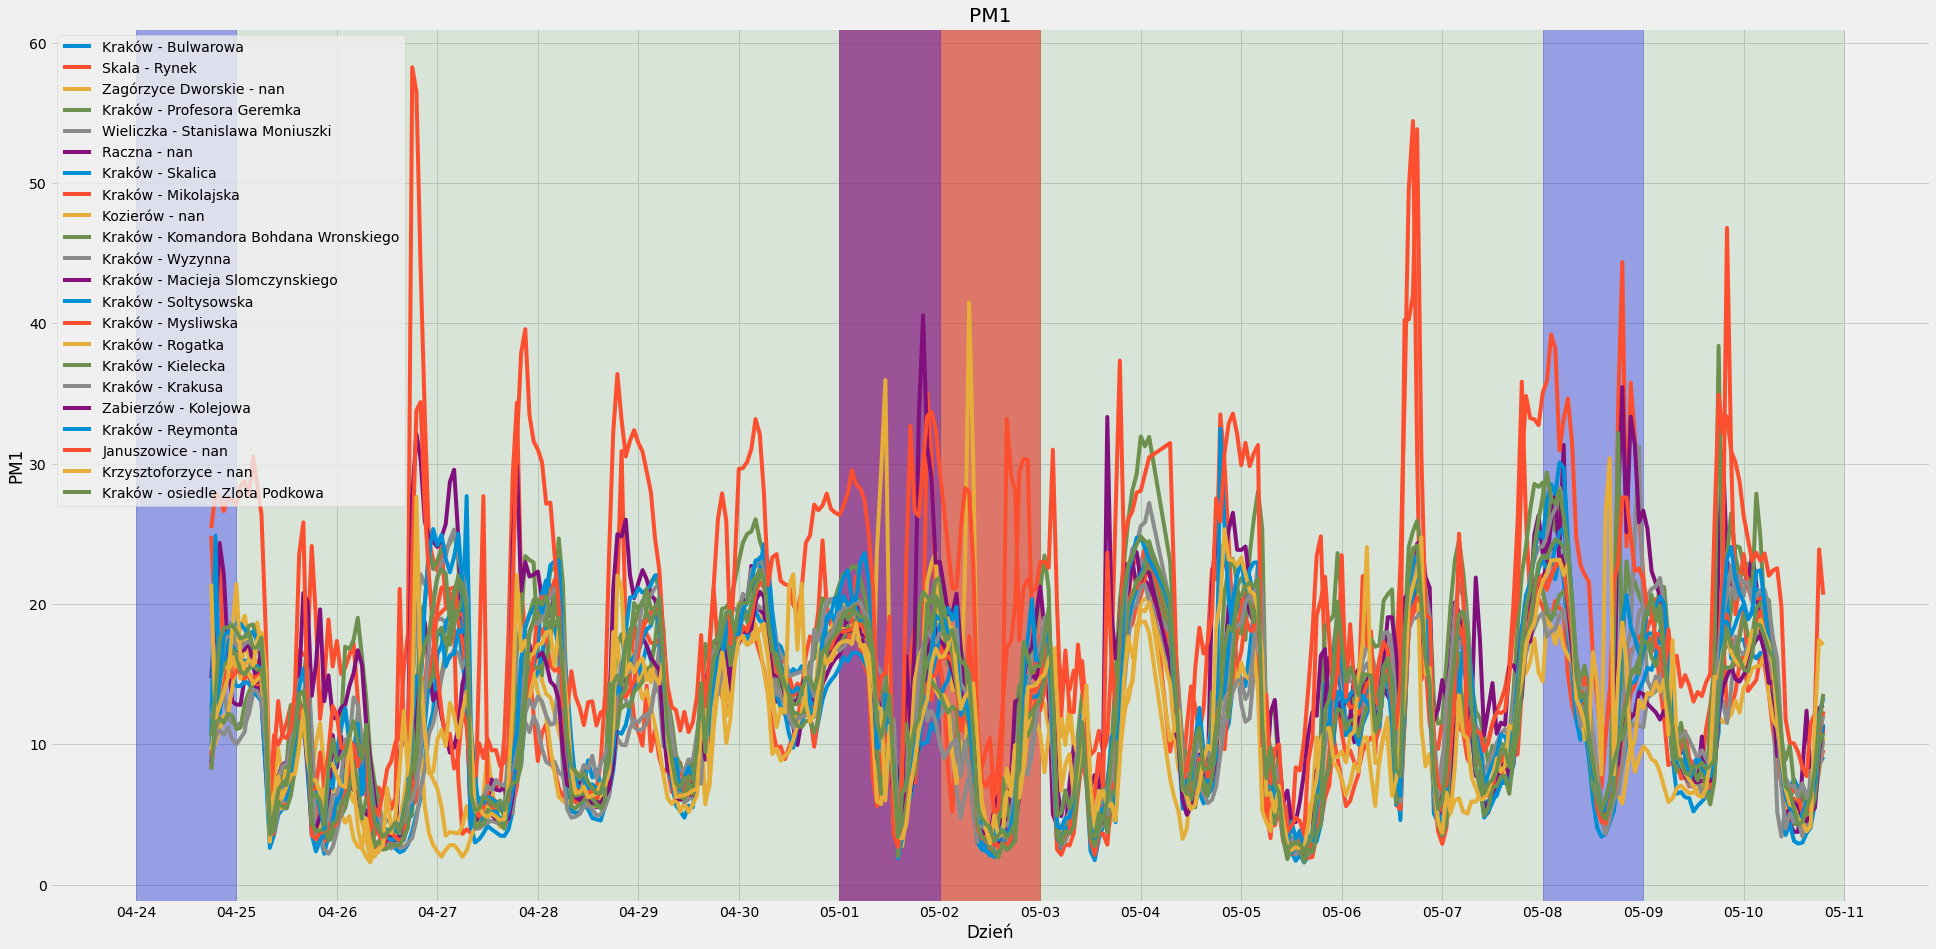

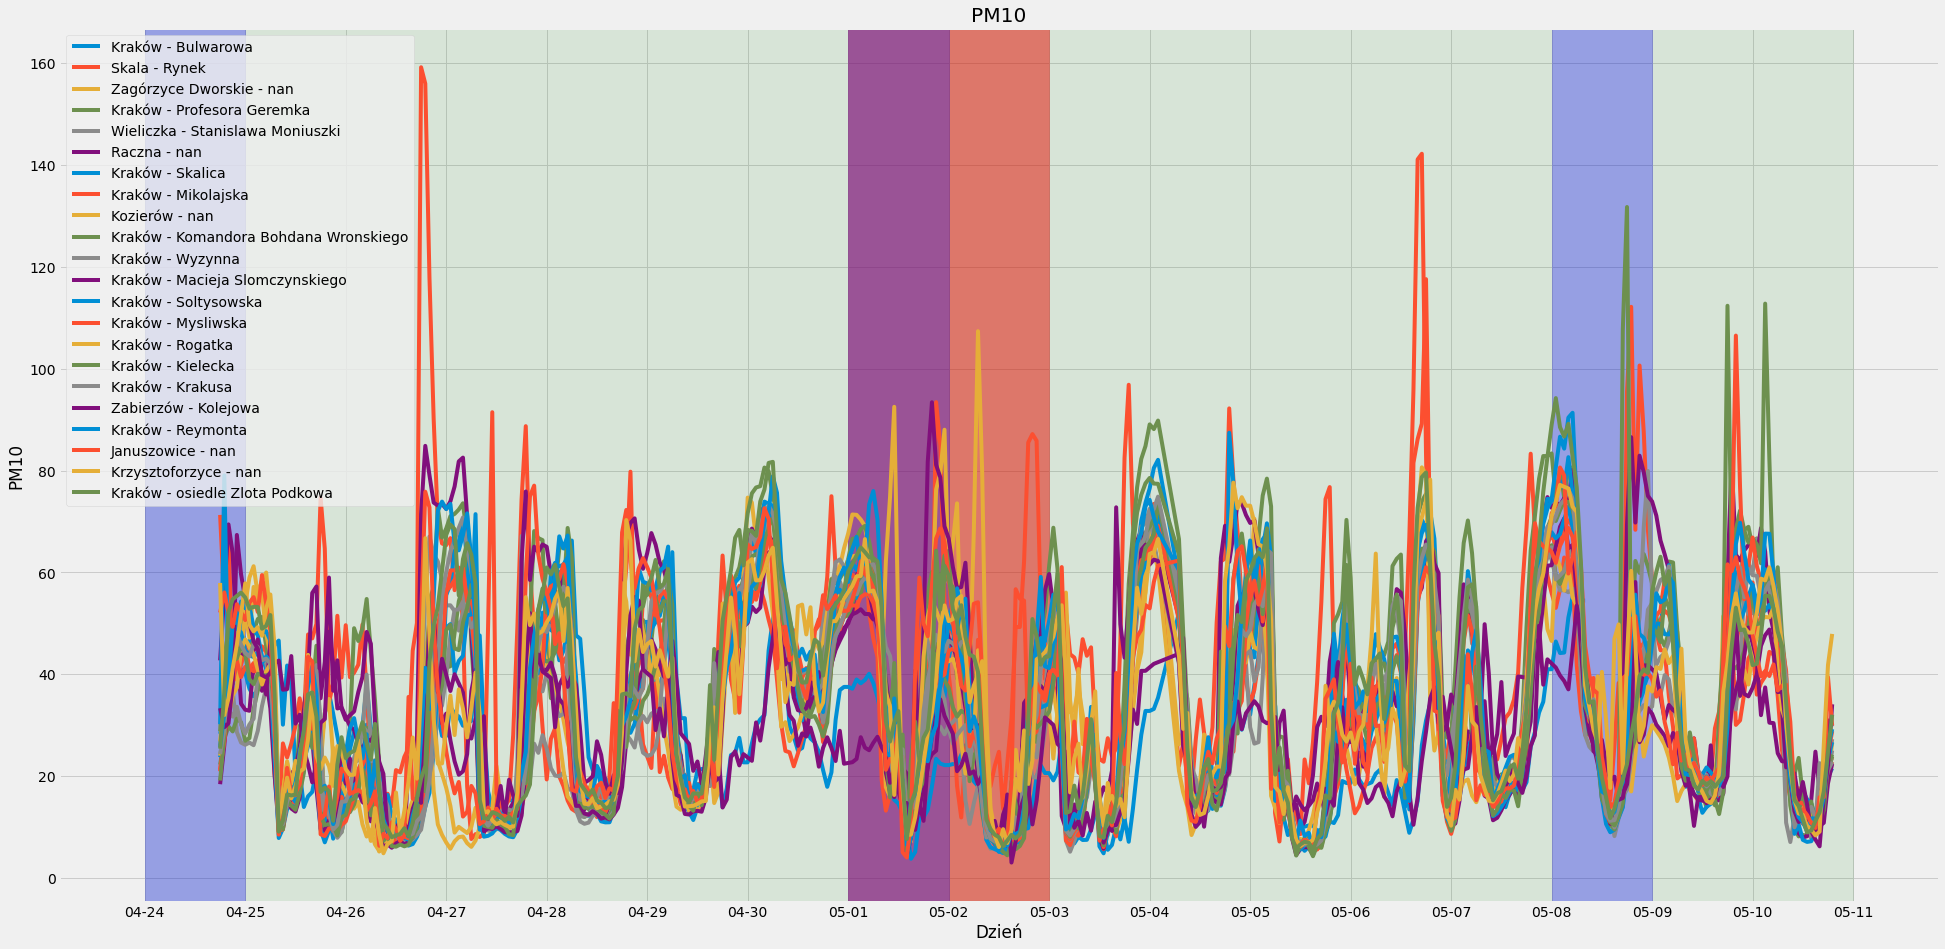

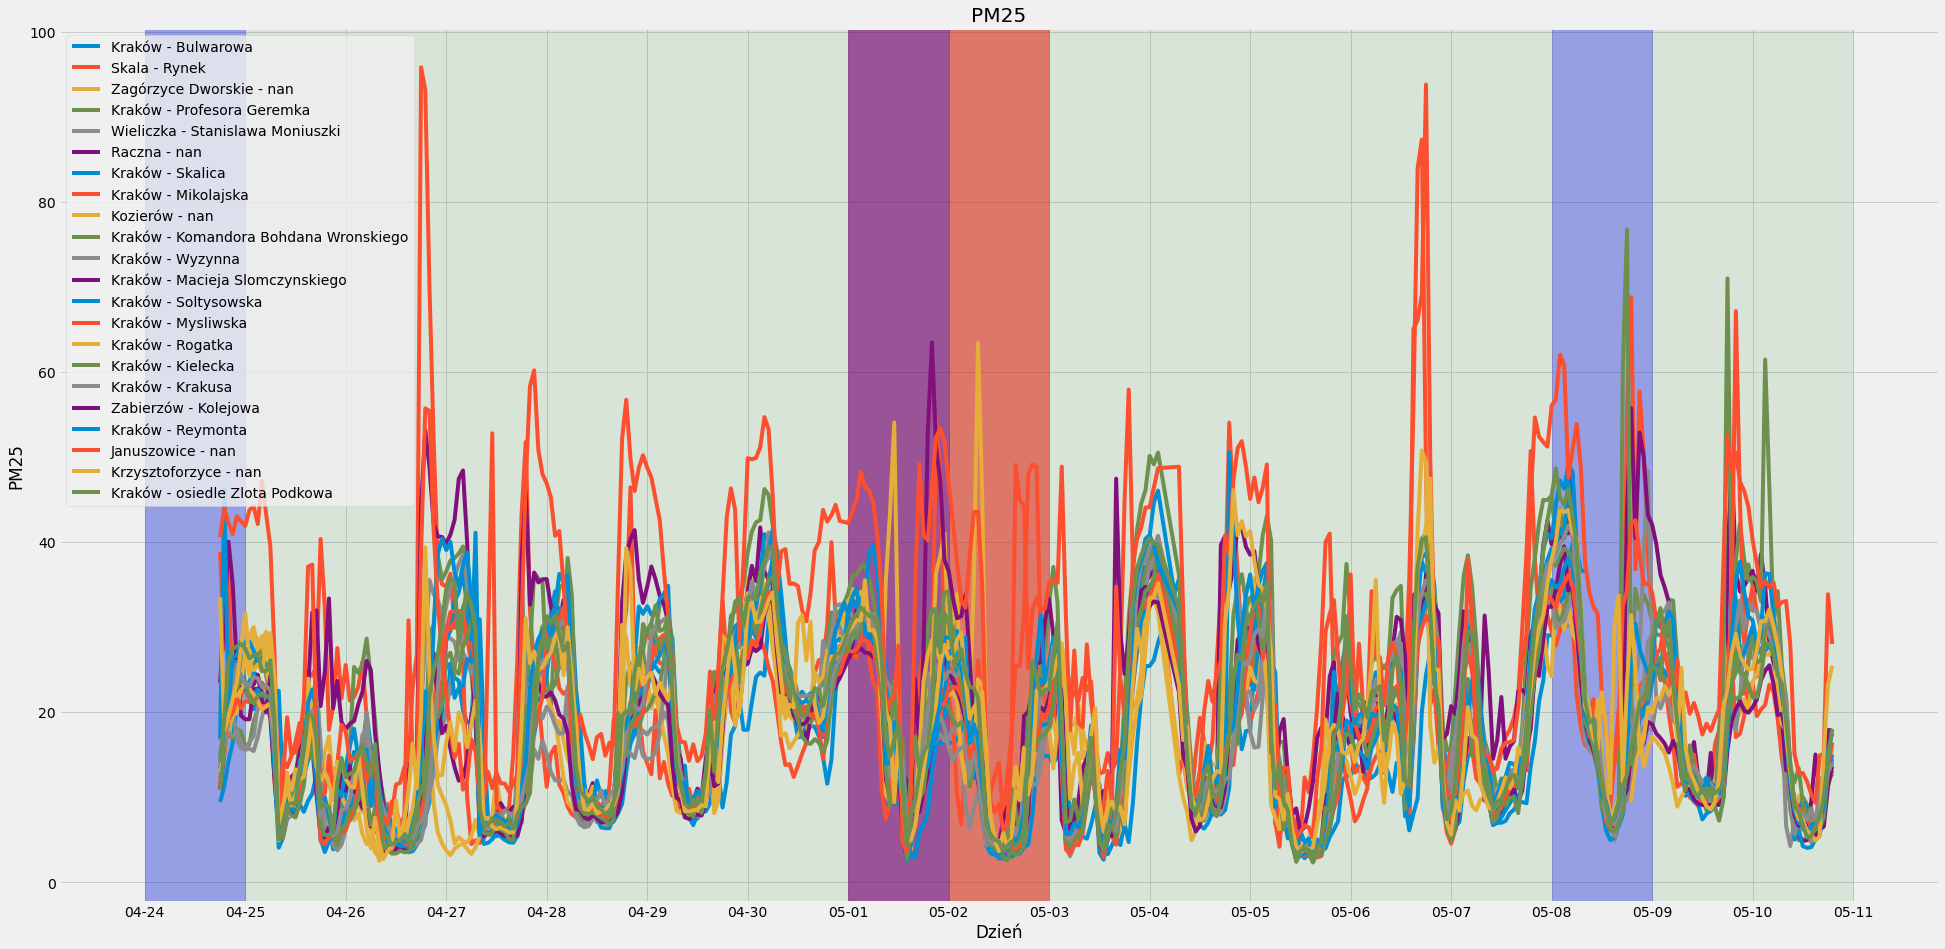

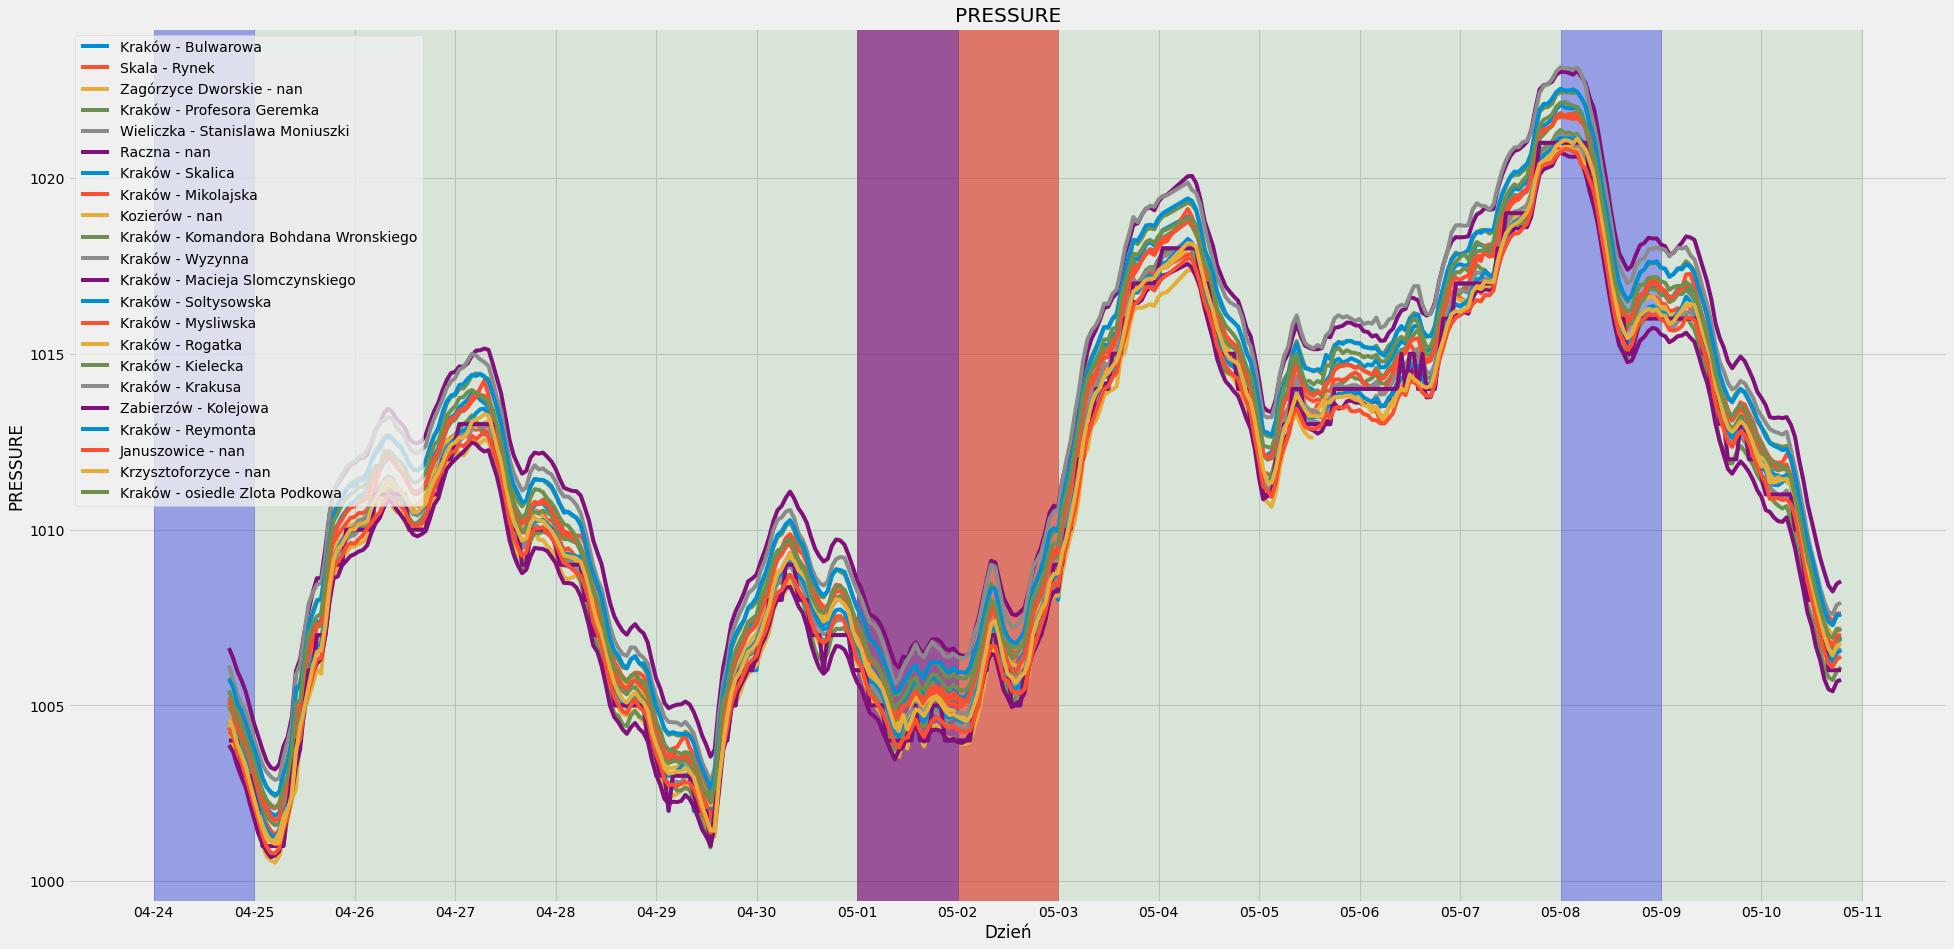

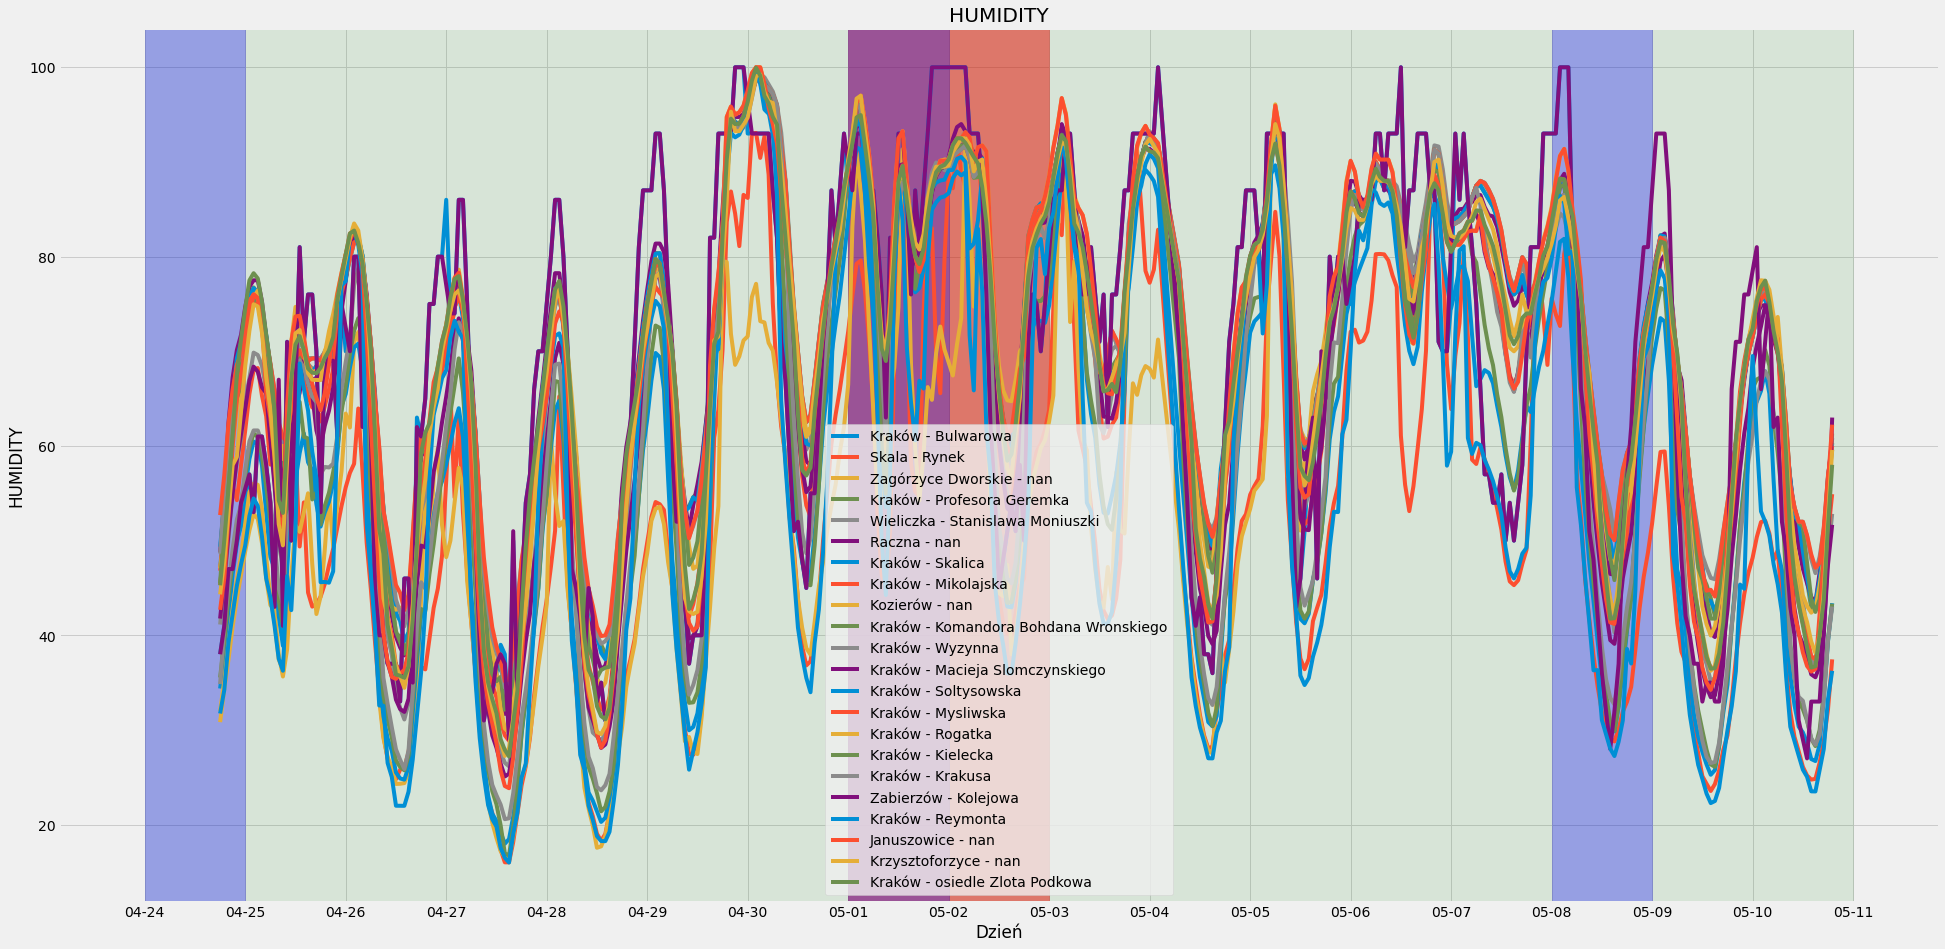

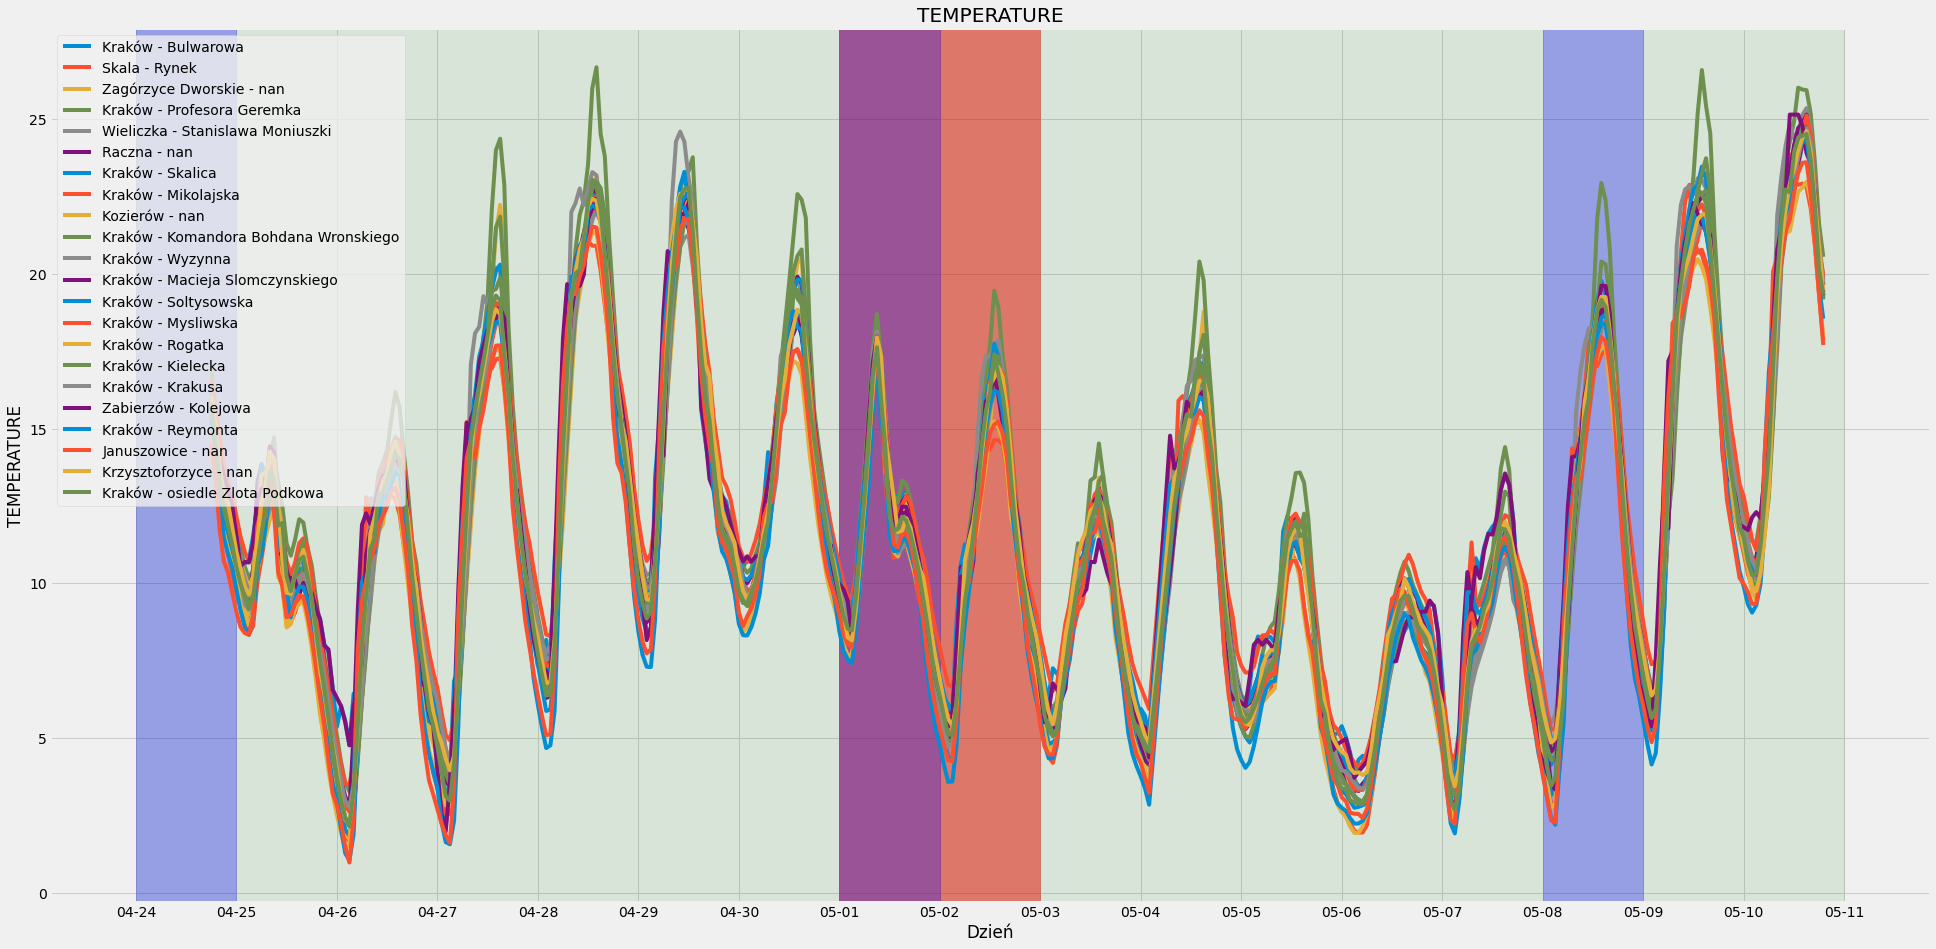

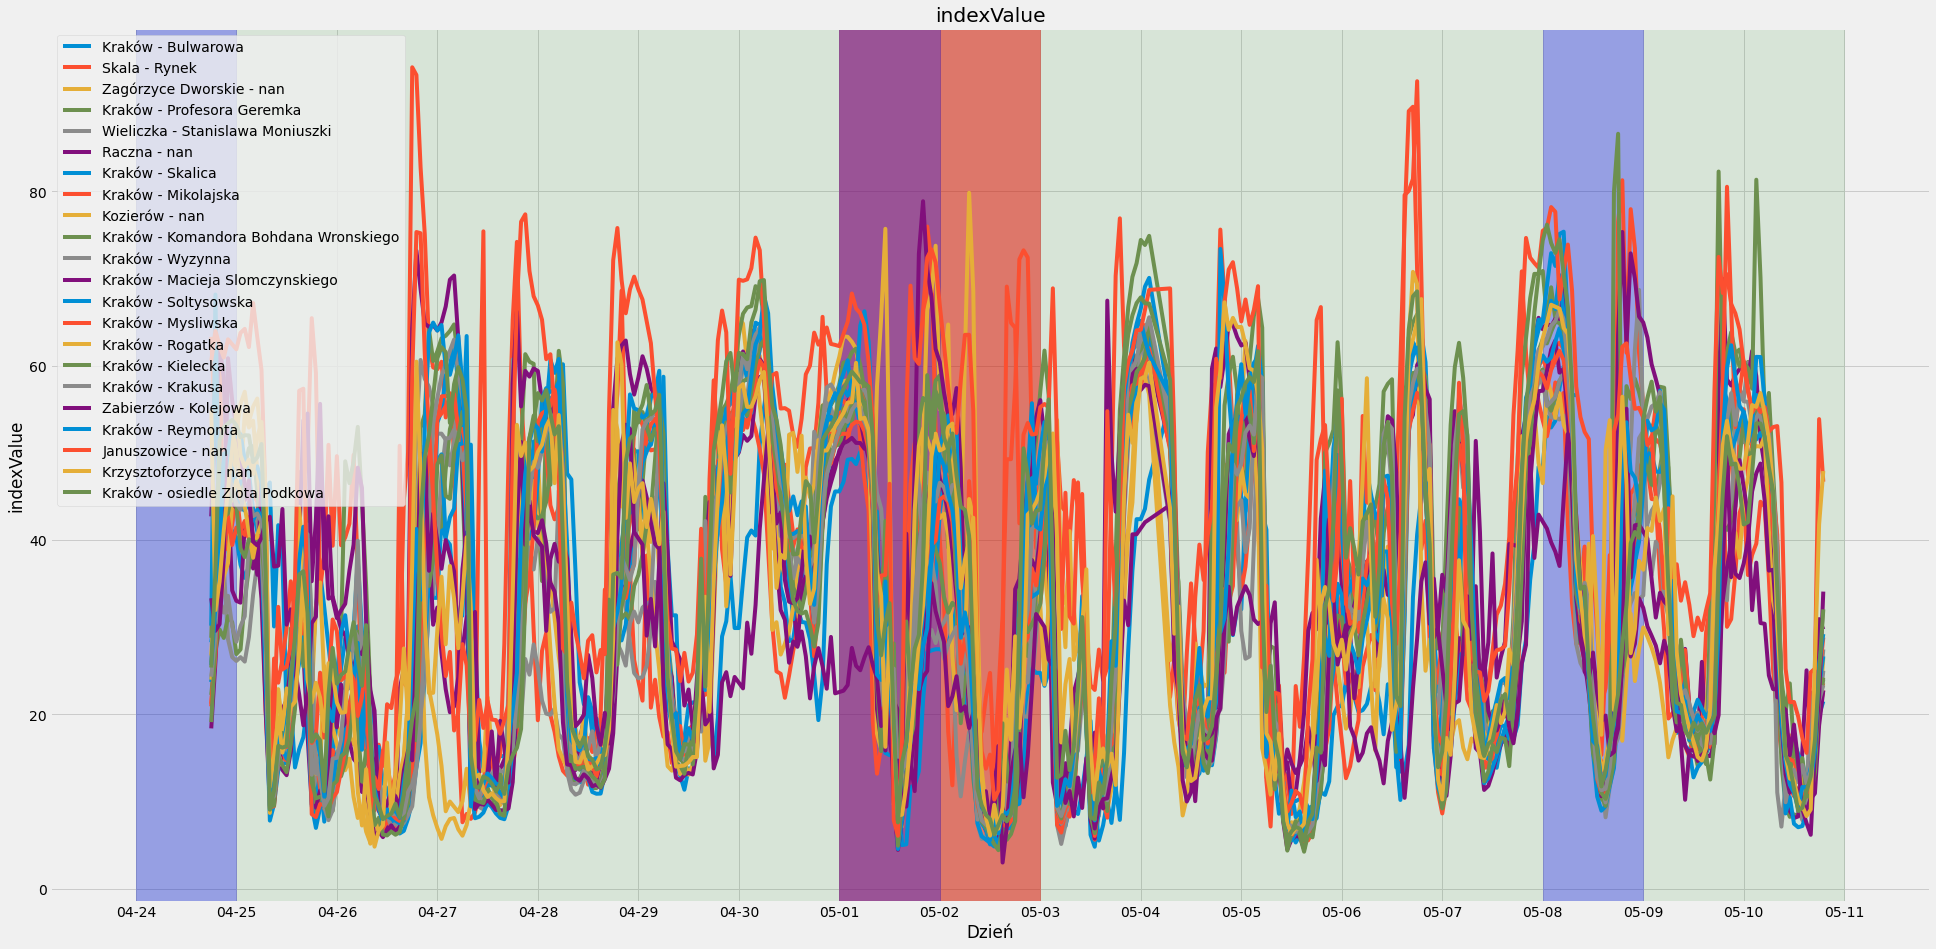

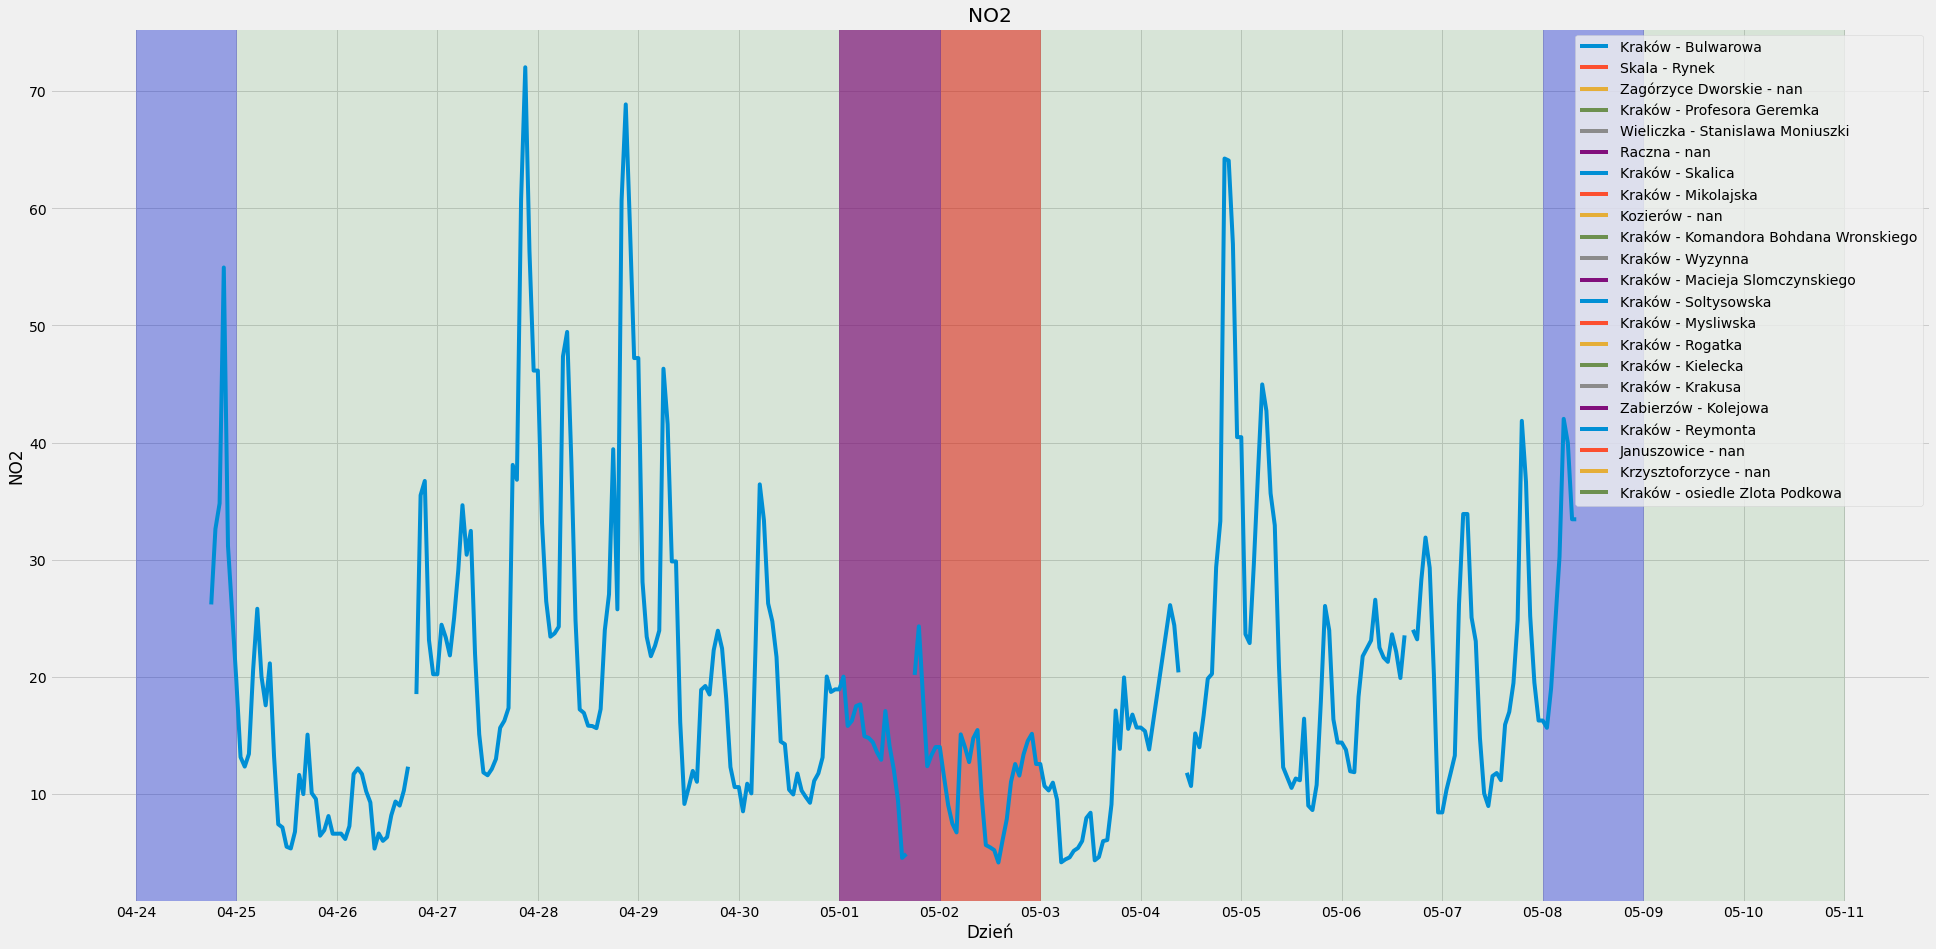

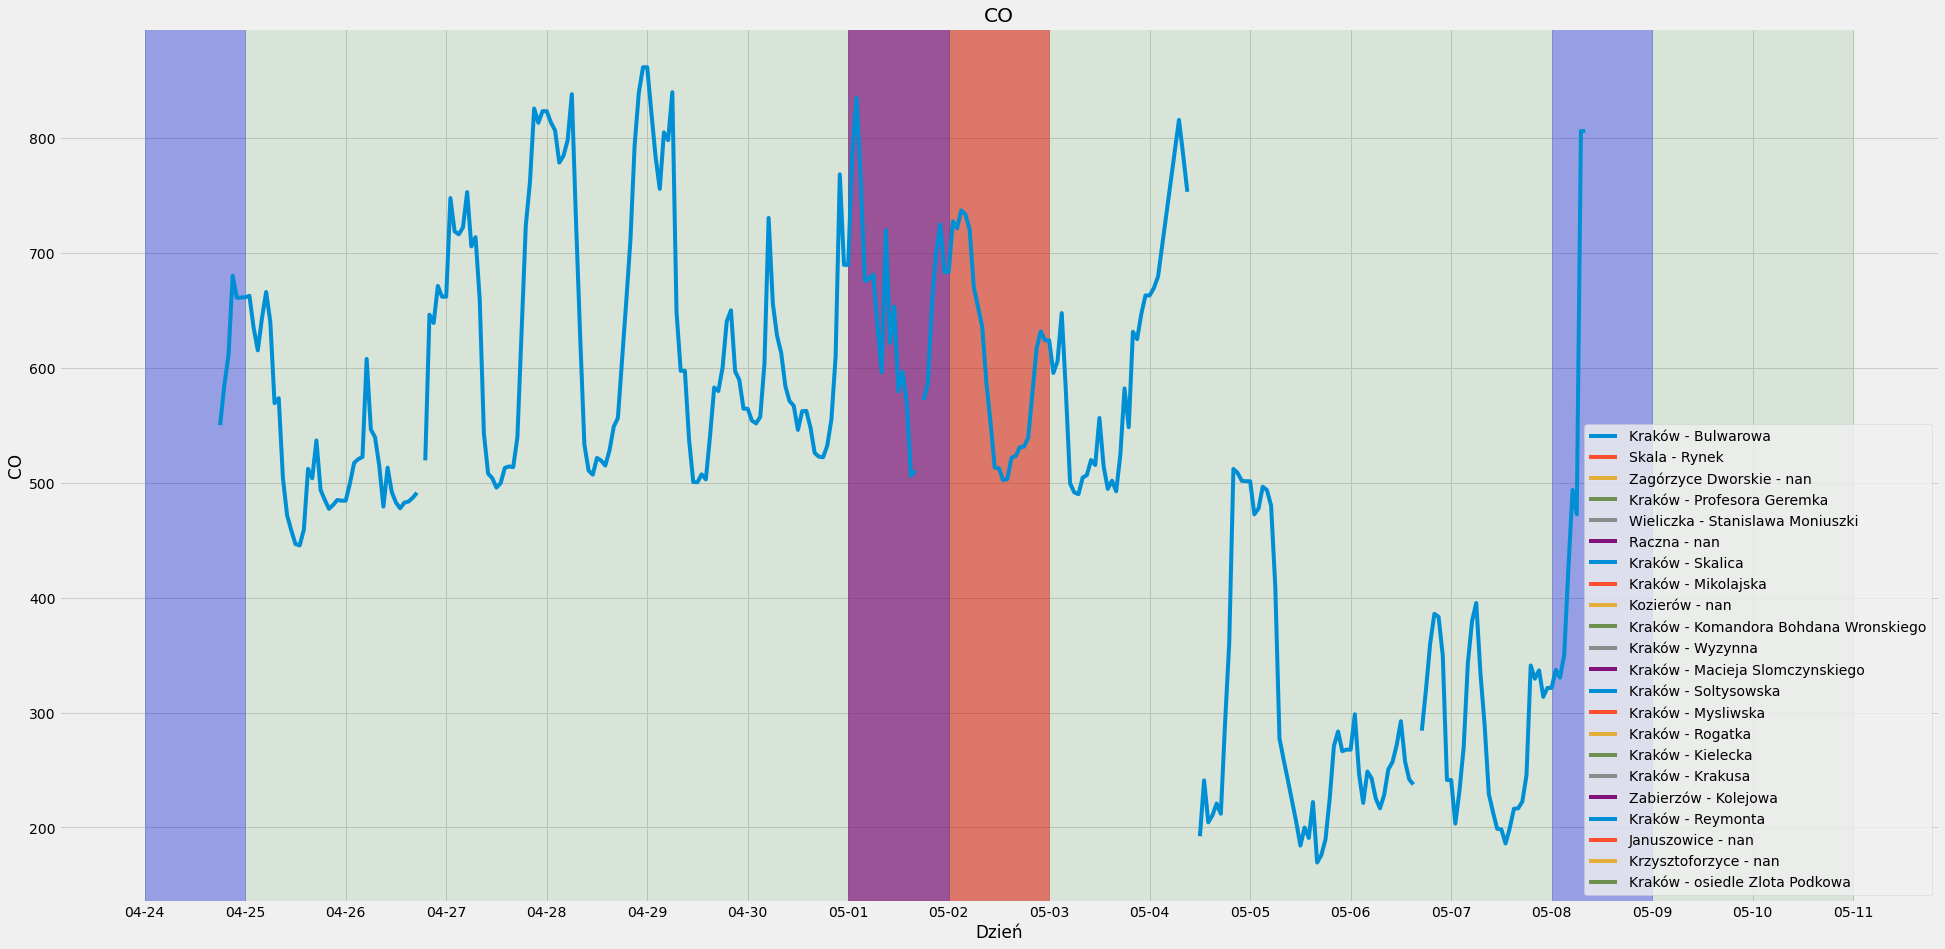

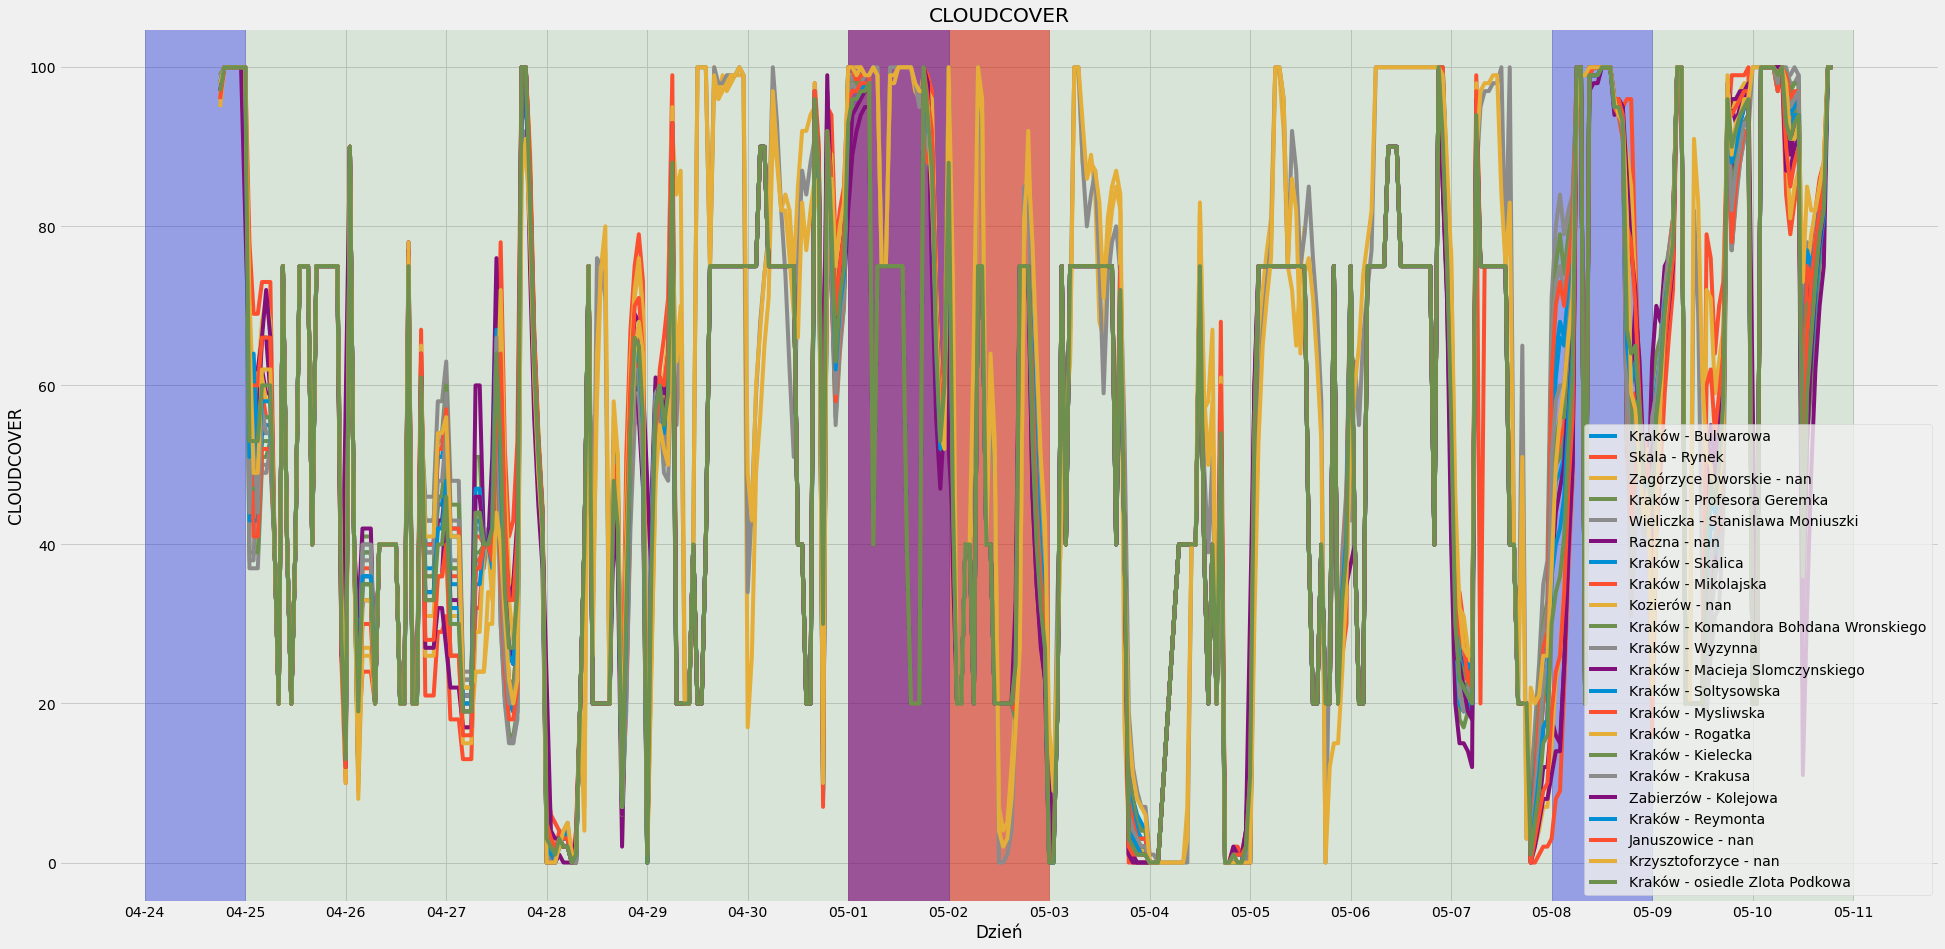

KeyboardInterrupt: 

In [40]:
columns_to_plot = np.delete(df.columns.values, (0, 1, 2))
columns_to_plot
for col in columns_to_plot:
    plotAllData(col)

In [ ]:
which_measure = 1

def plot_humidity(installation_id):
    measurements = measurements_by_installation_id[installation_id]
    if(measurements['HUMIDITY'].isnull().all()):
        return
    
    fig, ax = plt.subplots()
    fig.set_figheight(15)
    fig.set_figwidth(30)
    
    ax.plot(measurements.fromDataTime, measurements['HUMIDITY'], label=installations_labels[installation_id])

    setup_x_axis(ax, measurements)

    plt.xlabel('Dzień')
    plt.ylabel('Wilgotność [%]')
    plt.title('Wilgotność dla czujnika: %s' % (installations_labels[installation_id]))

  #  plot_name = 'HUMIDITY_' + str(installation_id)
  #  plt.savefig('./plots/%s_%d.png' % (plot_name, which_measure))
    plt.show()

In [ ]:
def plot_temperature(installation_id):
    measurements = measurements_by_installation_id[installation_id]
    if(measurements['TEMPERATURE'].isnull().all()):
        return
    
    fig, ax = plt.subplots()
    fig.set_figheight(15)
    fig.set_figwidth(30)
    
    ax.plot(measurements.fromDataTime, measurements['TEMPERATURE'], label=installations_labels[installation_id])
    
    setup_x_axis(ax, measurements)

    plt.xlabel('Dzień')
    plt.ylabel('Temperatura [C]')
    plt.title('Temperatura dla czujnika: %s' % (installations_labels[installation_id]))

 #   plot_name = 'TEMPERATURE_' + str(installation_id)
  #  plt.savefig('./plots/%s_%d.png' % (plot_name, which_measure))
    plt.show()

## Wykresy temperatury dla każdej stacji

In [ ]:
for id in installationd_id:
    plot_temperature(id)

## Wykresy wilgotności dla każdej stacji

In [ ]:
for id in installationd_id:
    plot_humidity(id)

## Wykresy dla każdego z kierunku

In [ ]:
def plotDataForRegion(installationIds, column, title):
    fig, ax = plt.subplots()

    fig.set_figheight(15)
    fig.set_figwidth(30)
    for id in installationIds:
        measurements = df.loc[df['installationId'] == id]
        ax.plot(measurements.fromDataTime, measurements[column], label=installations_labels[id])

    setup_x_axis(ax, measurements)

    plt.xlabel('Dzień')
    plt.ylabel(column)
    plt.title(title)
    plt.legend()

    plt.show()

In [ ]:
north = [313, 8126, 332, 10051, 329, 9899]
east = [11336, 19, 6076, 9902, 9891, 9903, 9919]
south = [9892, 1070, 7514, 9920, 9905]
west = [7012, 9996, 9923, 11489, 10039, 8077]

# north = installations[installations['region'] == 'N']['id']
# east = installations[installations['region'] == 'E']['id']
# south = installations[installations['region'] == 'S']['id']
# west = installations[installations['region'] == 'W']['id']

In [ ]:
plotDataForRegion(north, 'indexValue', 'Wartość zanieczyszczenia dla północnych stacji')
plotDataForRegion(east, 'indexValue', 'Wartość zanieczyszczenia dla wschodnich stacji')
plotDataForRegion(south, 'indexValue', 'Wartość zanieczyszczenia dla południowych stacji')
plotDataForRegion(west, 'indexValue', 'Wartość zanieczyszczenia dla zachodnich stacji')

In [ ]:
plotDataForRegion(north, 'TEMPERATURE', 'Wielkość temperatury dla północnych stacji')
plotDataForRegion(east, 'TEMPERATURE', 'Wielkość temperatury dla wschodnich stacji')
plotDataForRegion(south, 'TEMPERATURE', 'Wielkość temperatury dla południowych stacji')
plotDataForRegion(west, 'TEMPERATURE', 'Wielkość temperatury dla zachodnich stacji')

## Przetwarzanie danych

In [ ]:
from sklearn import preprocessing

data = df.drop(['installationId', 'fromDataTime', 'tillDateTime'] , axis='columns')
data.corr()

## Wykres korelacji

In [ ]:
import seaborn as sns

colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Korelacja Pearson', y=1.05, size=15)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,
square=True, cmap=colormap, linecolor='white', annot=True)

## Korelacja pomiędzy temperaturą, wilgotnością a prędkością wiatru

In [ ]:
from IPython.display import display, HTML

for id in installationd_id:
    dd = df.loc[df['installationId'] == id][['TEMPERATURE', 'HUMIDITY', 'WINDSPEED']]
    cor = dd.corr()
    print('Czujnik: ' + str(id))
    display(HTML(cor.to_html()))
    print()

## Uśrednienie wartości dla danych grup

In [ ]:
from sklearn.preprocessing import normalize

def plot_mean_data(group, title):
    data = df.loc[df['installationId'].isin(group)]
    dates = data['fromDataTime'].unique()

    means_temp = np.zeros(len(dates))
    means_hum = np.zeros(len(dates))
    means_index = np.zeros(len(dates))
    means_wind = np.zeros(len(dates))
    for d, i in zip(dates, range(len(dates))):
        m = data.loc[data['fromDataTime'] == d]['TEMPERATURE'].mean()
        means_temp[i] = m
        m = data.loc[data['fromDataTime'] == d]['HUMIDITY'].mean()
        means_hum[i] = m
        m = data.loc[data['fromDataTime'] == d]['indexValue'].mean()
        means_index[i] = m
        m = data.loc[data['fromDataTime'] == d]['WINDSPEED'].mean()
        means_wind[i] = m

    fig, ax = plt.subplots()
    fig.set_figheight(15)
    fig.set_figwidth(30)
    
    ax.plot(dates, means_temp, label='Temperatura')
    ax.plot(dates, means_hum, label='Wilgotność')
    ax.plot(dates, means_index, label='Jakość powietrza')
    ax.plot(dates, np.power(means_wind, 2), label='Prędkość wiatru')
    
    setup_x_axis(ax, 1)
    plt.legend()
    plt.xlabel('Czas')
    plt.title(title)
    
    plt.show()

In [ ]:
plot_mean_data(north, 'Wykres średniej temperatury, wilgotności, prędkości wiatru i jakości powietrza dla północnych stacji')
plot_mean_data(east, 'Wykres średniej temperatury, wilgotności, prędkości wiatru i jakości powietrza dla wschodnich stacji')
plot_mean_data(south, 'Wykres średniej temperatury, wilgotności, prędkości wiatru i jakości powietrza dla południowych stacji')
plot_mean_data(west, 'Wykres średniej temperatury, wilgotności, prędkości wiatru i jakości powietrza dla zachodnich stacji')

In [ ]:
import math
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.collections import LineCollection

def plot_winddirection(installation_id):
    measurements = measurements_by_installation_id[installation_id]
    if(measurements['TEMPERATURE'].isnull().all()):
        return
    x = []
    y = []
    dydx = []
    dates = []
    nan=float('nan')
    math.isnan(nan)
    for i, m in enumerate(measurements.iterrows()):
        x.append(m[1]['fromDataTime'].timetuple().tm_yday + m[1]['fromDataTime'].hour/24+737423)
        y.append(m[1]['WINDSPEED'])
        if(m[1]['WINDDIRECTION'] != m[1]['WINDDIRECTION']):
            dydx.append(dydx[i-1])
        else:
            dydx.append(m[1]['WINDDIRECTION'])
    # Create a set of line segments so that we can color them individually
    # This creates the points as a N x 1 x 2 array so that we can stack points
    # together easily to get the segments. The segments array for line collection
    x = np.array(x)
    y = np.array(y)
    dydx = np.array(dydx)

    # Create a set of line segments so that we can color them individually
    # This creates the points as a N x 1 x 2 array so that we can stack points
    # together easily to get the segments. The segments array for line collection
    # needs to be (numlines) x (points per line) x 2 (for x and y)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)
    plt.xlabel('Dzień')
    plt.ylabel('Szybkość wiatru [m/s]')
    plt.title('Szybkość wiatru dla czujnika: %s' % (installations_labels[installation_id]))

    # Use a boundary norm instead
    cmap = ListedColormap([(1, 1, 0.5), (1, 0.75, 0.75),(1, 0.5, 1), (1, 0.25, 0.75),(1, 0, 0.5), (1, 0.25, 0.25),(1, 0.5, 0), (1, 0.75, 0.25),(1, 1, 0.5)])
    norm = BoundaryNorm([0, 22.5, 67.5, 112.5, 157.5, 202.5, 247.5, 292.5, 337.5, 360], cmap.N)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(dydx)
    lc.set_linewidth(5)
    line = axs.add_collection(lc)
    fig.colorbar(line, ax=axs)

    fig.set_figheight(15)
    fig.set_figwidth(30)   
    axs.set_ylim(y.min(), y.max())
    axs.set_xlim(x.min(), x.max())
    setup_x_axis(axs, measurements)
    plt.show()

In [ ]:
for id in west:
    plot_winddirection(id)

# Analiza szeregów czasowych

## SARIMA

In [338]:
station_id = 313
y = df.loc[df['installationId'] == station_id][['fromDataTime', 'indexValue']].set_index(['fromDataTime'])

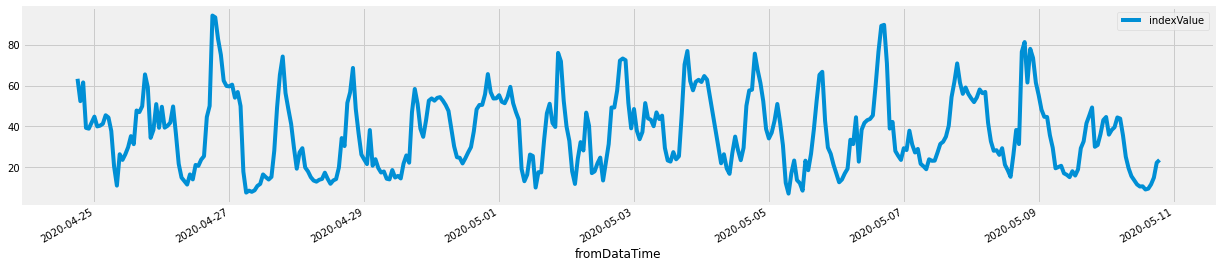

In [339]:
y.plot(figsize=(19, 4))
plt.show()

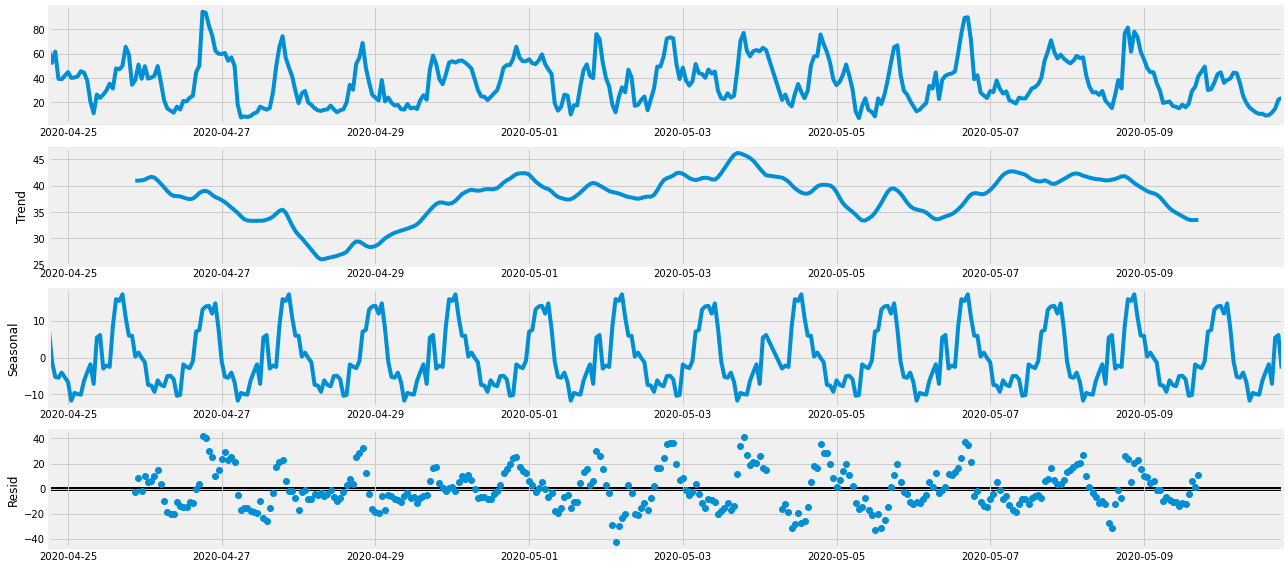

In [340]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive', freq=52)
fig = decomposition.plot()
plt.show()

In [341]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [342]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3908.694062456477
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3689.725160937901
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3574.10168031633


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\

ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3135.702177482204
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3524.454476045147


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\

ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3246.318981755857
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3083.096781076126


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\

ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3053.9695642024735
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3484.6837875868428
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3293.828730674219

c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\


ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3242.8908195132453


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\

ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2848.1903562770167
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3188.5629873073867


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\

ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2948.5663808946415
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2863.0061639458854

c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2804.408558764579
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2816.4346526215663
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2719.579222930102
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:3050.1034204864745


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\

ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:2678.1606751303884
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:2725.0752929807413


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\

ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:2712.872881699153
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:2763.9035350583326


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\

ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:2656.808768344523
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:2801.4959480028947
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2703.1697904645875
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:3027.715415015132


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\

ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:2664.4233820451864
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:2720.167924563761


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\

ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2704.2986709535517
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:2764.683269581399


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\

ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:2646.8648504003268
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:2819.5254457437386
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:2724.7827911196155
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:3035.199797525643


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\

ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:2662.354873014482
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:2723.0213186398987


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\

ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:2719.2709034599966
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:2729.5681393286195


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\

ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:2637.866758833571
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:2802.9336433312496
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2708.814626915455


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\

ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:3002.920285854583


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:2639.6411415193975
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:2716.8174559993704


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\

ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2710.610808292738
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:2722.7706374917666

c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:2619.7406456884055
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:2809.533421990067
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:2713.4977390025488
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:3035.850057807664


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\

ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:2672.055188392841
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:2712.6106473290574
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:2714.6035129482116


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\

ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:2756.675552062529


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:2654.448679109474
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:2803.354987931233
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2705.1654123241433


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\

ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:3029.715273539916


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:2666.025354122646
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:2713.431874129099


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\

ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2706.295006579258


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:2757.7275708690995


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:2648.8289050638355


In [380]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7485      0.039     19.175      0.000       0.672       0.825
ma.L1          0.2340      0.055      4.280      0.000       0.127       0.341
ma.S.L24      -0.8104      0.047    -17.086      0.000      -0.903      -0.717
sigma2         0.0115      0.001     17.442      0.000       0.010       0.013


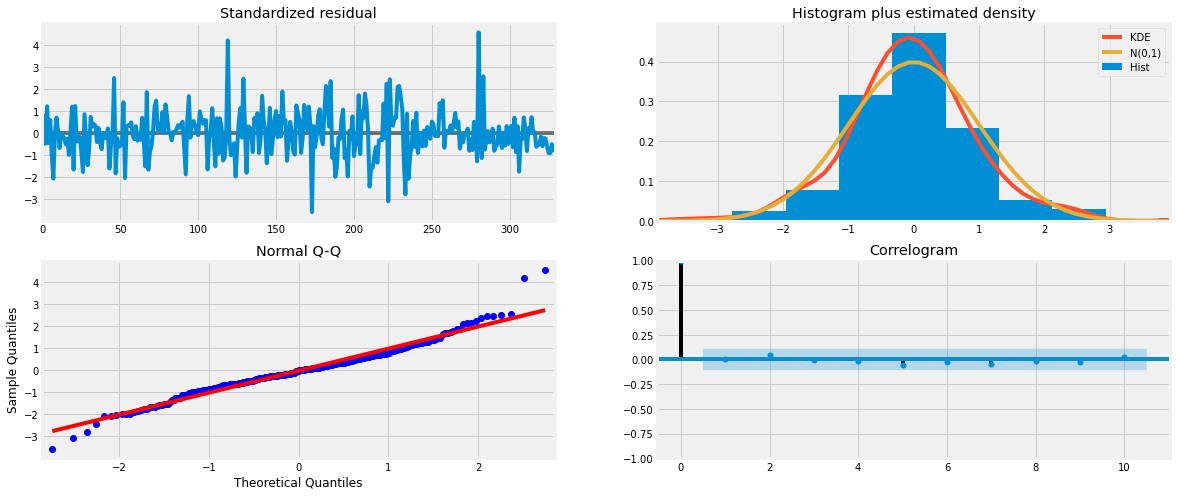

In [381]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

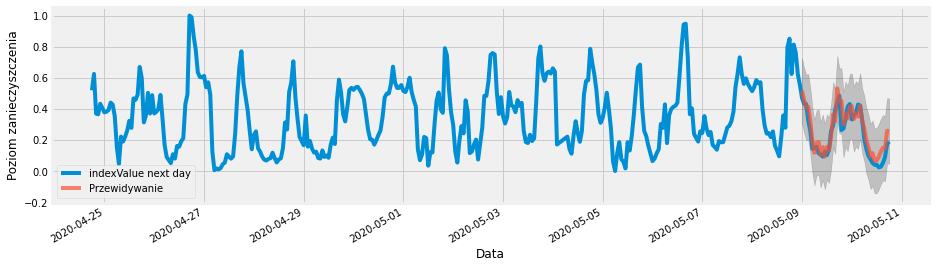

In [382]:
pred = results.get_prediction(start=pd.to_datetime('2020-05-09'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='Dane faktyczne')
pred.predicted_mean.plot(ax=ax, label='Przewidywanie', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Data')
ax.set_ylabel('Poziom zanieczyszczenia')
plt.legend()
plt.show()

In [346]:
y = df.loc[df['installationId'] == station_id][['fromDataTime', 'indexValue']].set_index(['fromDataTime'])
y = y['2020-05-05':]

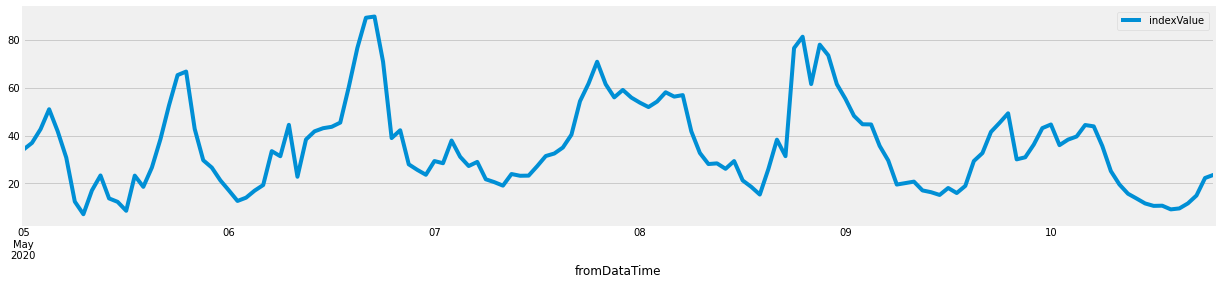

In [347]:
y.plot(figsize=(19, 4))
plt.show()

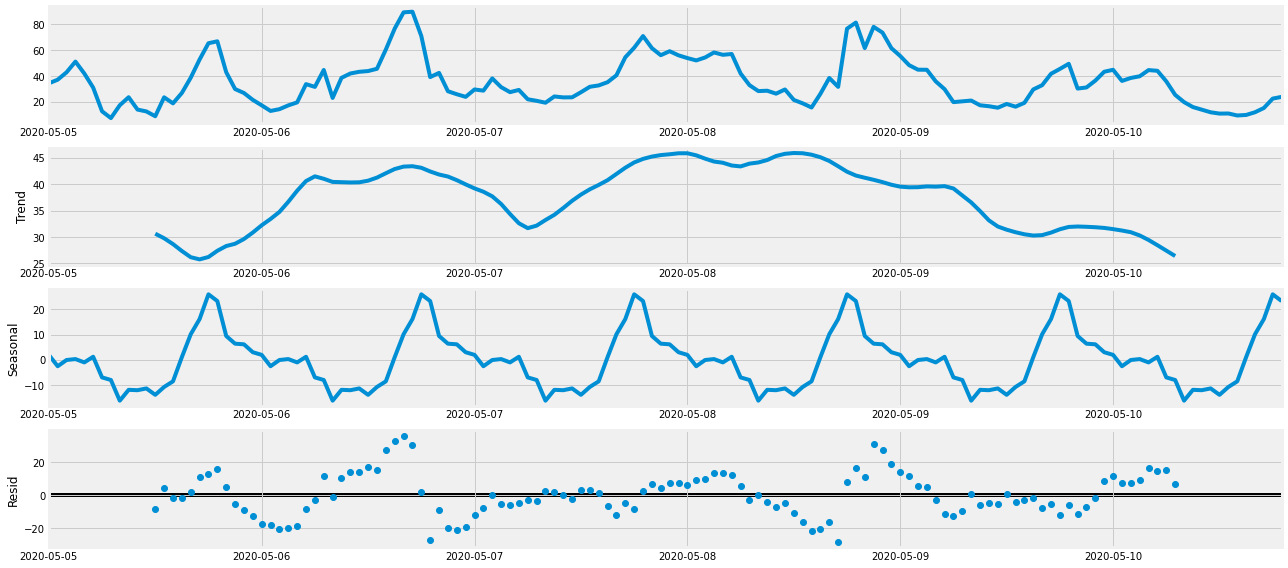

In [348]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [349]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [350]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1421.0814036318247
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1270.8884089352082
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1228.8483566366924
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1022.975896719578
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1218.9496742137042


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\u

ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1135.4656276401774
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1025.085046582311
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:999.3871752436473


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\u

ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1259.4005257284236
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1128.6834258167744
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1114.6076967198499
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:922.5933770643447
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1106.172991744881


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1025.2298763149042
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:945.5513234100345


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:907.9562507895204
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1007.8339265429046
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:918.8419140946376
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:1035.7229611921769
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:838.1656788166667
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:924.792950602297


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\u

ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:915.7189284680942
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:881.7474438647124
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:838.058802166332
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1000.5308930491419


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\u

ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:912.020658255414
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1027.7198672345785
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:833.7017922379138


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\u

ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:924.9033426419334
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:909.7158503608888
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:883.7472380082372


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\u

ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:833.1599951108518
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1014.1451677540256
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:928.4680560738116
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:1037.6435814033227


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\u

ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:842.667374026011
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:925.718692279638
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:925.7486733200378

c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'



ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:875.2692360226132


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:841.3377767081413
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1006.6080203081617
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:918.9320184798895
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:1027.9732412146786


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\u

ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:835.730026182096
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:925.556784266599


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:916.4279127746249
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:876.7311960827668


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:833.9779057588095
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1006.8500033312873
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:918.4105685190804
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1035.2448689567827


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\u

ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:840.1314175744751
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:915.5764533460203
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:915.9698464647015
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:875.9213089977778


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\u

ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:839.9636945080057
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1002.0438538290621
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:913.0640959400139
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:1028.7331306416331


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\u

ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:835.1170495521746
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:917.5653757888674
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:910.6284325666724


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\u

ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:877.912735780279


c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:835.0178362677709


In [351]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8598      0.056     15.410      0.000       0.750       0.969
ma.L1          0.0917      0.080      1.139      0.255      -0.066       0.249
ar.S.L12      -0.3529      0.115     -3.072      0.002      -0.578      -0.128
ma.S.L12      -1.0001    497.122     -0.002      0.998    -975.341     973.341
sigma2        63.3614   3.15e+04      0.002      0.998   -6.17e+04    6.18e+04


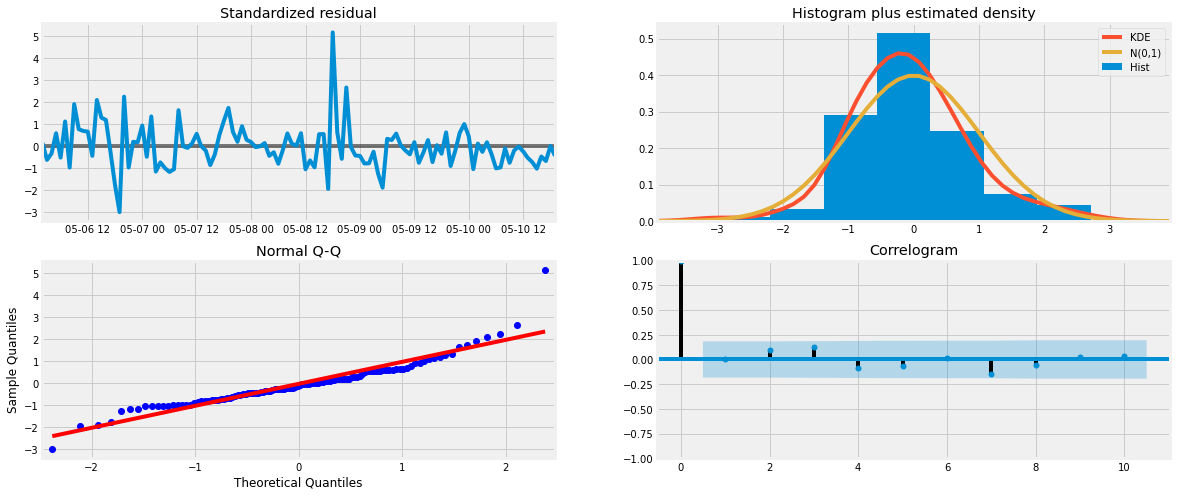

In [352]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

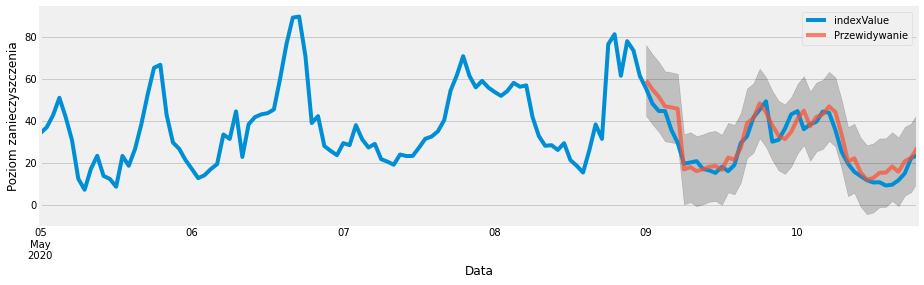

In [353]:
pred = results.get_prediction(start=pd.to_datetime('2020-05-09'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='Dane faktyczne')
pred.predicted_mean.plot(ax=ax, label='Przewidywanie', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Data')
ax.set_ylabel('Poziom zanieczyszczenia')
plt.legend()
plt.show()

# SARIMAX

In [354]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [355]:
dataset = df.loc[df['installationId'] == station_id][['fromDataTime', 'indexValue', 'TEMPERATURE', 'WINDSPEED', 'HUMIDITY']].set_index(['fromDataTime'])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 381 entries, 2020-04-24 18:00:00 to 2020-05-10 19:00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   indexValue   381 non-null    float64
 1   TEMPERATURE  381 non-null    float64
 2   WINDSPEED    381 non-null    float64
 3   HUMIDITY     381 non-null    float64
dtypes: float64(4)
memory usage: 14.9 KB


In [356]:
steps=-1
dataset_for_prediction= dataset.copy()
dataset_for_prediction['Actual']=dataset_for_prediction['indexValue'].shift(steps)
dataset_for_prediction.head(3)

indexValue  TEMPERATURE  WINDSPEED  HUMIDITY  Actual
fromDataTime                                                             
2020-04-24 18:00:00       63.30        14.56        2.6     45.34   52.37
2020-04-24 19:00:00       52.37        13.73        3.1     49.24   61.53
2020-04-24 20:00:00       61.53        12.51        2.6     52.30   39.29

In [357]:
dataset_for_prediction=dataset_for_prediction.dropna()

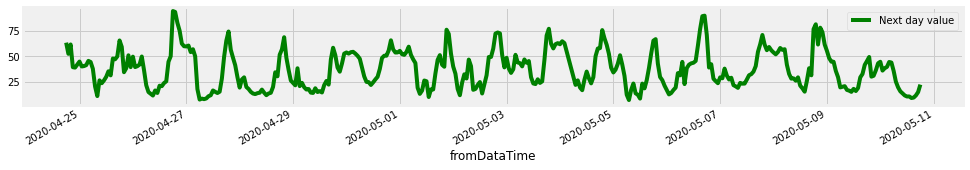

In [358]:
dataset_for_prediction['indexValue'].plot(color='green', figsize=(15,2))
plt.legend(['Next day value', 'indexValue'])

In [359]:
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['indexValue', 'TEMPERATURE', 'WINDSPEED', 'HUMIDITY']])
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input

In [360]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output

In [361]:
X.rename(columns={0:'indexValue', 1:'TEMPERATURE', 2:'WINDSPEED', 3:'HUMIDITY'}, inplace=True)
X.index=dataset_for_prediction.index
X.head(2)

indexValue  TEMPERATURE  WINDSPEED  HUMIDITY
fromDataTime                                                     
2020-04-24 18:00:00    0.644891     0.581270   0.225806  0.380582
2020-04-24 19:00:00    0.519403     0.543899   0.279570  0.431205

In [362]:
y.rename(columns={0:'indexValue next day'}, inplace= True)
y.index=dataset_for_prediction.index
y.head(2)

indexValue next day
fromDataTime                            
2020-04-24 18:00:00             0.519403
2020-04-24 19:00:00             0.624569

In [363]:
train_size=int(len(dataset) *0.7)
test_size = int(len(dataset)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

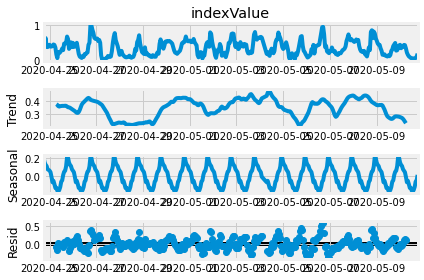

In [364]:
import statsmodels.api as sm
seas_d=sm.tsa.seasonal_decompose(X['indexValue'],model='add',freq=24);
fig=seas_d.plot()
fig.set_figheight(4)
plt.show()

In [365]:
from statsmodels.tsa.stattools import adfuller
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [366]:
y_test=y['indexValue next day'][:train_size].dropna()
test_adf(y_test, "")

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary 


## Budowanie modelu

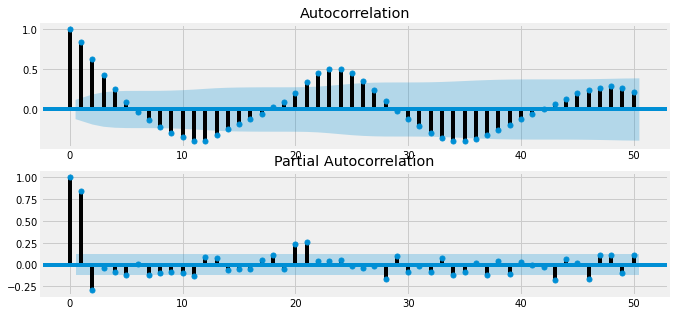

In [367]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_test, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=50, ax=ax[1])
plt.show()

In [368]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(train_y, 
 exogenous= train_X,
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-395.104, BIC=-366.466, Time=0.359 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-383.209, BIC=-361.731, Time=0.030 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-381.263, BIC=-356.205, Time=0.148 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-381.501, BIC=-356.443, Time=0.280 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-385.168, BIC=-367.270, Time=0.066 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=-392.990, BIC=-360.773, Time=0.391 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=-380.331, BIC=-348.113, Time=0.416 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=-381.587, BIC=-352.949, Time=0.396 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=-380.611, BIC=-351.973, Time=0.254 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=-403.347, BIC=-367.550, Time=0.512 seconds
Near non-invertible roots for order 

In [369]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  266
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 211.674
Date:                Mon, 11 May 2020   AIC                           -403.347
Time:                        10:08:39   BIC                           -367.550
Sample:                             0   HQIC                          -388.965
                                - 266                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept    2.338e-05      0.000      0.093      0.926      -0.000       0.001
indexValue      0.3567      0.210      1.697      0.090      -0.055       0.769
TEMPERATURE    -0.0758      0.160     -0.474      0.636      -0.389       0.238
WINDSPEED      -0.1033      0.056     -1.853      0.064      -0.213       0.006
HUMIDITY       -0.0123      0.095     -0.130      0.897      -0.198       0.174
ar.L1          -0.0961      2.450     -0.039      0.969      -4.898       4.706
ar.L2           0.5273      1.737      0.304      0.762      -2.878       3.932
ma.L1          -0.2242      2.548     -0.088      0.930      -5.218       4.770
ma.L2          -0.7609      2.537     -0.300      0.764      -5.733       4.211
sigma2          0.0117      0.001     12.908      0.000       0.010       0.013
===================================================================================
Ljung-Box (Q):                       86.59   Jarque-Bera (JB):                75.11
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             0.25
Prob(H) (two-sided):                  0.85   Kurtosis:                         5.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [370]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model= SARIMAX(train_y, 
 exog=train_X,
 order=(2,1,2),
 enforce_invertibility=False, enforce_stationarity=False)

c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [371]:
results = model.fit()

c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [372]:
predictions = results.predict(start=train_size
                             , end=train_size+test_size+(steps)-1
                             , exog=test_X)

c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [373]:
forecast_1 = results.forecast(steps=test_size-1, exog=test_X)

c:\users\karko\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [374]:
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])

In [375]:
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['indexValue next day']
predictions.rename(columns={0:'Pred'}, inplace=True)

Text(0.5, 0, 'Data')

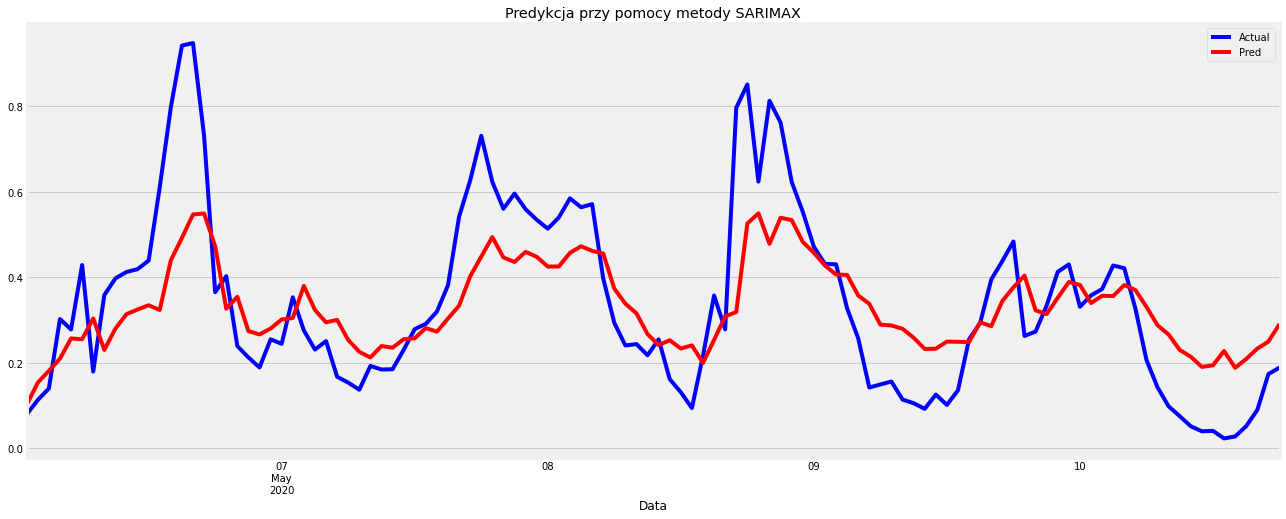

In [376]:
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
ax = predictions['Pred'].plot(legend=True,
                             color='red',
                             figsize=(20,8),
                             title='Predykcja przy pomocy metody SARIMAX')
ax.set_xlabel('Data')

In [377]:
forecast= pd.DataFrame(forecast_1)
forecast.reset_index(drop=True, inplace=True)
forecast.index=test_X.index
forecast['Actual'] =scaler_output.iloc[train_size:, 0]
forecast.rename(columns={0:'Forecast'}, inplace=True)

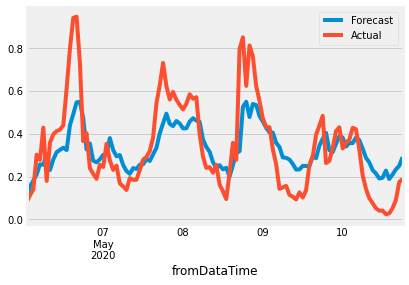

In [378]:
forecast['Forecast'].plot(legend=True)
forecast['Actual'].plot(legend=True)